In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

import torchvision 
from torchvision import transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader 

from torchmetrics.classification import BinaryPrecision, BinaryRecall, BinaryConfusionMatrix, BinaryAccuracy

import matplotlib.pyplot as plt 
import numpy as np

# Device Configuration

In [2]:
device = torch.device('cuda')

# Loading Images
```sql
test/
    ├── not-a-santa/
    │   ├── 0.not-a-santa.jpg
    │   └── 1.not-a-santa.jpg
    └──  santa/
        ├── 0.santa.jpg
        └── 1.santa.jpg
    
test/
    ├── not-a-santa/
    │   ├── 0.not-a-santa.jpg
    │   └── 1.not-a-santa.jpg
    └──  santa/
        ├── 0.santa.jpg
        └── 1.santa.jpg
```

- Main folders: `train` and `test`
- Inside each main folder: one folder per category `santa` and `not-a-santa`
- Inside each class folder: image files 

# Data Preprocessing and Augmentation

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_transforms = transforms.Compose([    
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  
])

# Load the Data

In [4]:
train_dataset = ImageFolder("/kaggle/input/is-that-santa-image-classification/is that santa/train", transform=train_transforms)
train_dataloader =  DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = ImageFolder("/kaggle/input/is-that-santa-image-classification/is that santa/test", transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

# Building the CNN Model 

In [5]:
class BinaryNet(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size = 3, stride = 1, padding=1), # (3,150,150) -> (16,150,150)
            nn.BatchNorm2d(16), 
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (16, 75, 75)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride = 1, padding = 1), #(16, 75, 75) -> (32,75,75)
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (32, 75, 75) -> (32, 37, 37)

            nn.Conv2d(in_channels=32, out_channels=64,  kernel_size =3, padding=1),  # (32, 37, 37) -> # (64, 37, 37)
            nn.BatchNorm2d(64),
            nn.ELU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), # (64, 37, 37) -> (32, 18, 18)

            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 18 * 18, 512), 
            nn.ELU(),
            nn.Linear(512, 1)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x): 
        x = self.feature_extractor(x)
        x = self.classifier(x)
        x = self.sigmoid(x)
        return x


# Training

In [6]:
model = BinaryNet()
model.to(device) # Move the model to the device
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
print(model)

BinaryNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ELU(alpha=1.0)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20736, out_features=512, bias=True

In [7]:
num_epochs = 10 
steps_per_epoch = 100 
validation_steps = 50 

for epoch in range(num_epochs): 
    # Trainig Loop
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dataloader): 
        if i >= steps_per_epoch: 
            break 
            
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / steps_per_epoch 
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validaiton Loop
    model.eval() 
    val_running_loss = 0.0 
    correct = 0 
    total = 0 
    with torch.no_grad(): 
        for j, (images, labels) in enumerate(test_dataloader): 
            if j>= validation_steps: 
                break
            images, labels = images.to(device), labels.to(device).float()
            
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            
            val_running_loss += loss 
            
            preds = (outputs.squeeze() > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / validation_steps 
    val_accuracy = correct / total 
    print(f"Val Loss: {val_loss:.4f}, Val Acc :{val_accuracy:.4f}")
                
        

Epoch 1/10, Training Loss: 0.0982
Val Loss: 0.4508, Val Acc :0.5844
Epoch 2/10, Training Loss: 0.0687
Val Loss: 0.1560, Val Acc :0.8295
Epoch 3/10, Training Loss: 0.0579
Val Loss: 0.1055, Val Acc :0.9042
Epoch 4/10, Training Loss: 0.0454
Val Loss: 0.0993, Val Acc :0.9010
Epoch 5/10, Training Loss: 0.0495
Val Loss: 0.0913, Val Acc :0.9075
Epoch 6/10, Training Loss: 0.0446
Val Loss: 0.0953, Val Acc :0.9010
Epoch 7/10, Training Loss: 0.0389
Val Loss: 0.0910, Val Acc :0.9042
Epoch 8/10, Training Loss: 0.0406
Val Loss: 0.0935, Val Acc :0.8896
Epoch 9/10, Training Loss: 0.0343
Val Loss: 0.1117, Val Acc :0.9026
Epoch 10/10, Training Loss: 0.0376
Val Loss: 0.1002, Val Acc :0.9026


In [8]:
# Evaluate the Model
precision_metric = BinaryPrecision().to(device)
recall_metric = BinaryRecall().to(device)
accuracy_metric = BinaryAccuracy().to(device)
conf_matrix_metric = BinaryConfusionMatrix().to(device)

model.eval()

all_preds = []
all_labels = []

with torch.no_grad(): 
    for images, labels in test_dataloader: 
        images = images.to(device)
        labels = labels.to(device).float() 

        output = model(images)        
        preds = torch.round(output).squeeze()                  
                
        precision_metric.update(preds, labels)
        recall_metric.update(preds, labels)
        accuracy_metric.update(preds, labels)
        conf_matrix_metric.update(preds, labels)
        
        # Collect predictions and labels for later analysis
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute all metrics
precision = precision_metric.compute()
recall = recall_metric.compute()
accuracy = accuracy_metric.compute()
conf_matrix = conf_matrix_metric.compute()

# Print the results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


# Reset the metrics for next use
precision_metric.reset()
recall_metric.reset()
accuracy_metric.reset()
conf_matrix_metric.reset()

Precision: 0.9189189076423645
Recall: 0.8831169009208679
Accuracy: 0.9025974273681641
Confusion Matrix:
tensor([[284,  24],
        [ 36, 272]], device='cuda:0')


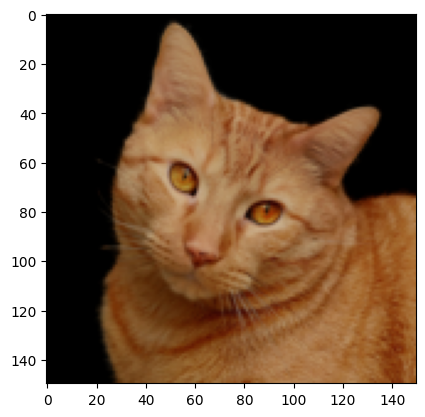

Pred:  Not Santa :( 
Label:  Not Santa :(


In [9]:
image, label = next(iter(test_dataloader))
image = image.to(device)
output = model(image)

# Move the output and label back to teh cpu for displaying
output = output.cpu().detach().numpy()
label = label.cpu().numpy()

mean = torch.tensor([0.5, 0.5, 0.5])  
std = torch.tensor([0.5, 0.5, 0.5])   
image = image[0].cpu() * std[None, :, None, None] + mean[None, :, None, None]
image = torch.clamp(image, 0, 1)

plt.imshow(image[0].cpu().permute(1, 2, 0))  
plt.show()

def isSanta(cond):
    return "Not Santa :(" if not bool(cond) else "Santa :D"

print("Pred: ", isSanta(output[0][0] > 0.5), "\nLabel: ", isSanta(label[0]))

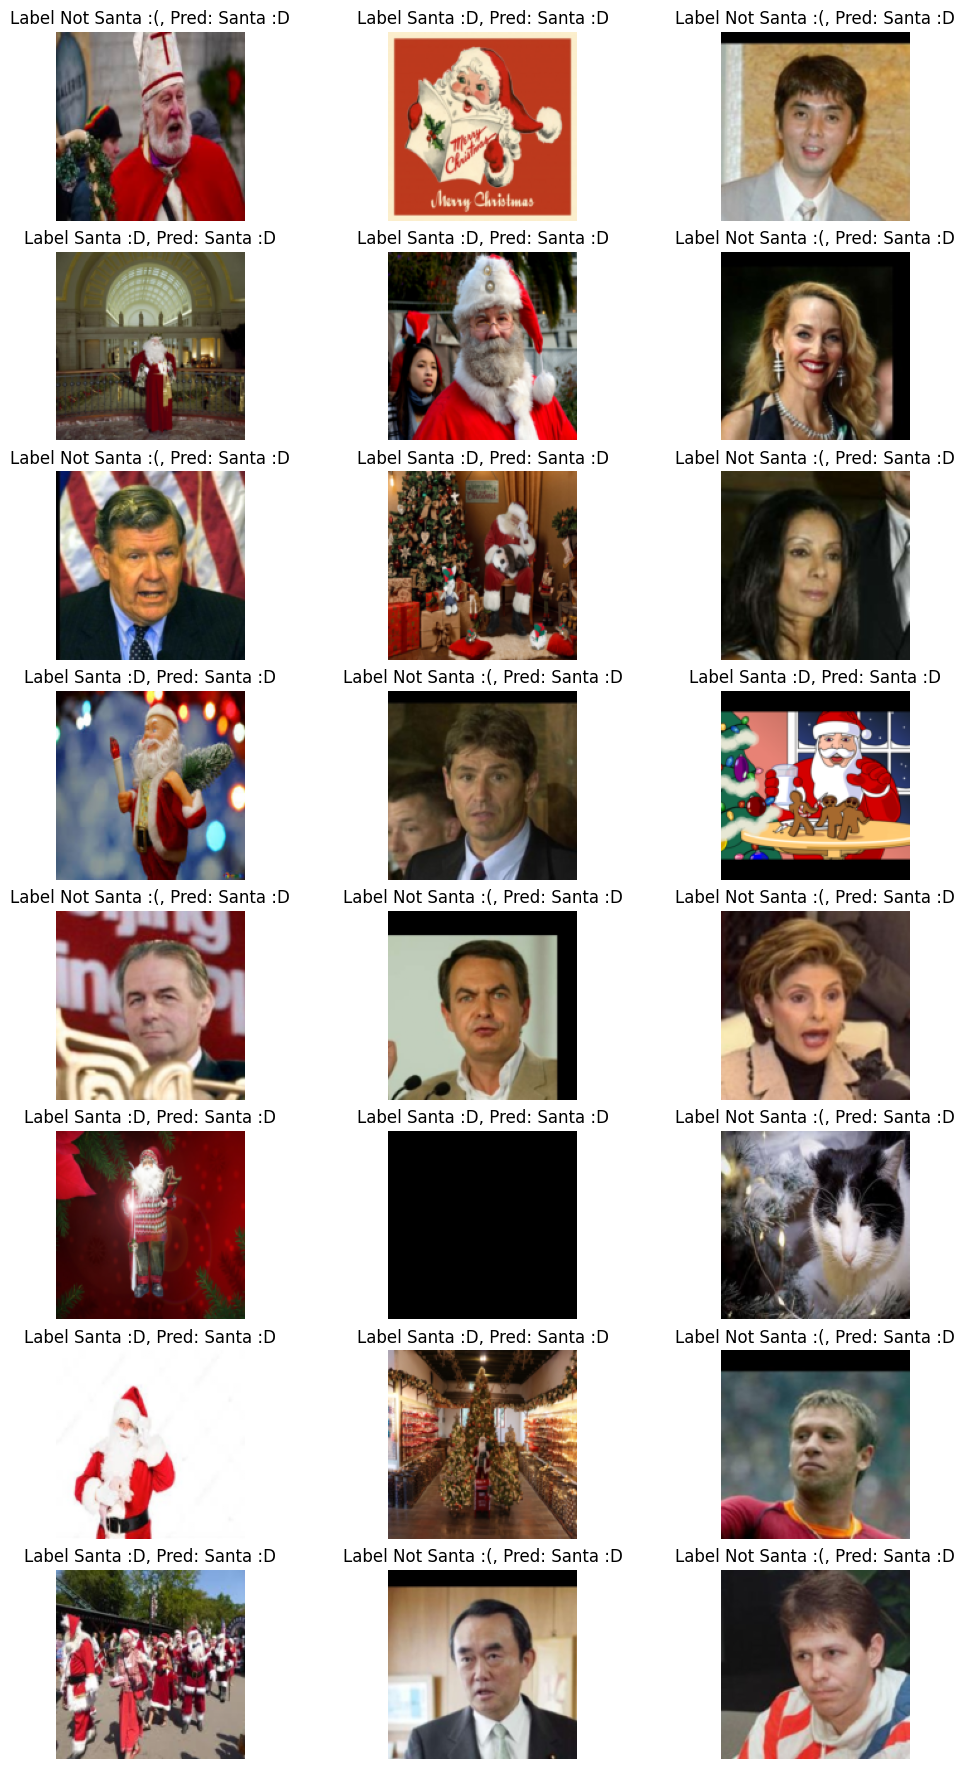

In [10]:
fig, axes = plt.subplots(8,3, figsize=(10,20))
fig.tight_layout(pad=0.13, rect=[0, 0.03, 1, 0.91])

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

model.eval() 
for i, ax in enumerate(axes.flat): 
    random_index = np.random.randint(len(test_dataset))

    image, label = test_dataset[random_index]
    image= image.unsqueeze(0).to(device)
    label = isSanta(label)

    output = model(image).cpu().detach().numpy()

    image = image[0].cpu() * std[None, :, None, None] + mean[None, :, None, None]
    image = torch.clamp(image, 0, 1)

    ax.imshow(image.cpu().squeeze(0).permute(1, 2, 0)) 
    ax.set_title(f"Label {label}, Pred: {isSanta(output[0])}")
    ax.axis('off')
    